In [1]:
# Note:
# please, activate conda environment before:
# >>> conda activate rainnet2024-env

# Here we provide a brief demonstration of prediction abilities 
# of the RainNet2024 family of models for precipitation nowcasting.

# We also compare results with a standard model of tracking and
# advection provided by the PySteps library

In [1]:

# provide the respective CatRaRE ID
catrare_event_id = 20815

In [2]:
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from pysteps import motion, nowcasts
from pysteps.utils import transformation

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow.keras.models import load_model
from efficientnet.tfkeras import EfficientNetB4
import segmentation_models as sm

%matplotlib inline

Pysteps configuration file found at: /home/georgy/miniforge3/envs/innomaus_nowcasting/lib/python3.9/site-packages/pysteps/pystepsrc



2024-07-02 13:25:44.995675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


In [3]:
# set-up thresholds for hourly rainfall accumulations
thresholds = [5, 10, 15, 20, 25, 30, 40]

In [4]:
# load the respective sample data
data = np.load(f"data/{catrare_event_id}.npy")
print(data.shape)

(60, 256, 256)


In [5]:
# Define the nowcast routine for the stadard model from the PySteps library
def pysteps_nowcast(event_instance_id, path_to_data="data/", lookback=2, pred_ts=12):
    """
    input: event_instance_id in the format {event_id}_{ind}
    output: nowcast in mm/h

    Parameters:
    path_to_data: YW data in .npy format for each Event_ID in CatraRe
    lookback: timesteps to consider as input
    pred_ts: how much timesteps to nowcast

    Notes:
    Input data is the YW dataset which is in mm/h.
    
    """
    # split up event_instance_id
    event_id, idx = [int(i) for i in event_instance_id.split("_")]

    # read data
    data_instance = np.load(os.path.join(path_to_data, f"{event_id}.npy"))

    # sanity check for NaNs (filling with zeros)
    data_instance = np.nan_to_num(data_instance)
    
    # input data
    # two last scans
    inputs_mmh = data_instance[ idx-lookback:idx , ::, ::]

    # data conversion float16 --> float32 is needed for advection routine
    inputs_mmh = inputs_mmh.astype(np.float32)
    
    # ground truth data to compare with
    ground_truth_mmh = data_instance[ idx:idx+pred_ts , ::, ::]

    ### nowcasting steps
    # data transformation mm/h --> dB (reflectivity)
    inputs_dbr = transformation.dB_transform(inputs_mmh, threshold=0.1, zerovalue=-15.0)[0]
    
    # calculate optical flow with the Lukas-Kanade method
    V = motion.get_method("LK")(inputs_dbr)

    # run the model
    nowcast_dbr = nowcasts.get_method("extrapolation")(inputs_dbr[-1, :, :], V, pred_ts)

    # convert back to mm/h
    nowcast_mmh = transformation.dB_transform(nowcast_dbr, threshold=-10.0, inverse=True)[0]

    # sanity check for NaNs (filling with zeros)
    nowcast_mmh[np.isnan(nowcast_mmh)] = 0

    # convertion float32 --> float16
    nowcast_mmh = nowcast_mmh.astype(np.float16)
    
    return nowcast_mmh, ground_truth_mmh

In [7]:
# run calculations for the 24th time step of the sample event (20815): "20815_24"
# pyst_n: pysteps nowcast
# pyst_o: respective observations with which we can compare predictions
pyst_n, pyst_o = pysteps_nowcast("20815_24")

print(pyst_n.shape, pyst_o.shape)

(12, 256, 256) (12, 256, 256)


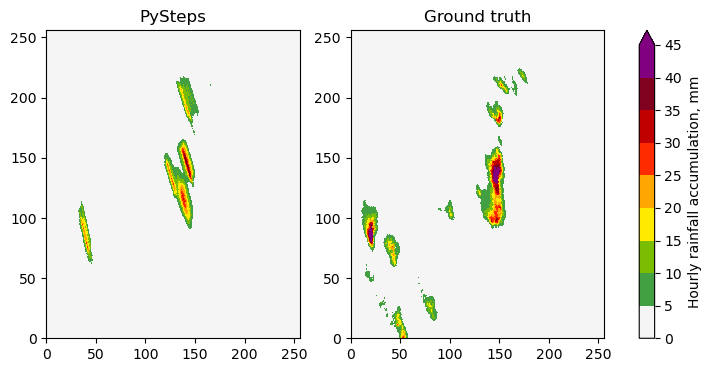

In [8]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

cmap = colors.LinearSegmentedColormap.from_list("", ["whitesmoke", "green", "yellow", "orange", "red", "maroon", "purple"])
boundaries = np.concatenate([[0], np.linspace(min(thresholds), max(thresholds), len(thresholds)+1), [45]])
norm = colors.BoundaryNorm(boundaries, cmap.N)

im1 = ax1.pcolormesh(pyst_n.sum(axis=0)/12, cmap=cmap, norm=norm)
im2 = ax2.pcolormesh(pyst_o.sum(axis=0)/12, cmap=cmap, norm=norm)

ax1.set_title("PySteps")
ax2.set_title("Ground truth")

fig.colorbar(im1, ax=[ax1, ax2], label="Hourly rainfall accumulation, mm", extend="max")

In [9]:
# load the RainNet2024 model
path_models = "models/"
rn24 = load_model(os.path.join(path_models, f"rainnet2024.keras"))

In [10]:
# helpers for data preprocessing
def l2d(l):

    d = {}

    key, value = l[0].split("_")

    values = [value]

    d[key] = values

    for element in l[1:]:

        nkey, nvalue = element.split("_")

        if nkey == key:

            values.append(nvalue)

            d[key] = values

        else:

            key = nkey

            values = [nvalue]

            d[key] = values
    
    return d


# the routine for RainNet2024 predictions
def rainnet_nowcast_batch(keys_for_batch, model_instance=rn24, path_to_data="data/", lookback=4, pred_ts=12):
    """
    input: event_instance_id in the format {event_id}_{ind}
    output: nowcast in mm/h

    Parameters:
    path_to_data: YW data in .npy format for each Event_ID in CatraRe
    lookback: timesteps to consider as input
    pred_ts: how much timesteps to nowcast

    Notes:
    Input data is the YW dataset which is in mm/h.
    
    """
    dict_for_keys = l2d(keys_for_batch)
    
    # data for batch
    dict_for_data = {key:data for key, data in zip(dict_for_keys.keys(), 
                                                   [np.load(os.path.join(path_to_data, f"{k}.npy")) for k in dict_for_keys.keys()])}
       
    # batch construction
    # shape: batch, channels, W, H
    # two modes: for regression and segmentation
    # batch_x is similar for both
    batch_x = np.array([dict_for_data[k.split("_")[0]][ int(k.split("_")[1])-lookback : int(k.split("_")[1]) ] for k in keys_for_batch])

    batch_y = np.array([dict_for_data[k.split("_")[0]][ int(k.split("_")[1]) : int(k.split("_")[1])+pred_ts ] for k in keys_for_batch])
    
    # preprocessing
    batch_x = batch_x.astype(np.float32)
    
    # rainnet2024 takes mm/h divided by 400
    batch_x = batch_x / 400.0

    # move scans dimension to the last position
    batch_x = np.moveaxis(batch_x, 1, -1)

    nowcast = []

    for j in range(pred_ts):
        # make prediction
        if j==11:
            pred = model_instance.predict(batch_x, verbose=2)
        else:
            pred = model_instance.predict(batch_x, verbose=0)
        # append prediction to holder
        nowcast.append(pred)
        # append prediction to the input shifted on one step ahead
        batch_x = np.concatenate([batch_x[::, ::, ::, 1:], pred], axis=-1)


    # postprocessing
    # the shape of nowcast is predts, batch, w, h, 1
    # --> predts, batch, w, h
    nowcast = np.squeeze(nowcast)
    # --> batch, predts, w, h
    #nowcast = np.moveaxis(nowcast, 0, 1)
    # convert from div400 to mm/h
    nowcast = nowcast * 400.0
    # Get rid of infs and Nans
    nowcast[~np.isfinite(nowcast)] = 0
    # Get rid of negative values
    nowcast = np.where(nowcast<0, 0, nowcast)
    # convertion float32 --> float16
    nowcast = nowcast.astype(np.float16)

    batch_y = np.squeeze(batch_y)
    
    return nowcast, batch_y

In [11]:
# Run the RainNet2024
# _n, and _o notation is similar to the one from PySteps (pyst) prediction
rn24_n, rn24_o = rainnet_nowcast_batch(["20815_24"])

1/1 - 0s - 343ms/epoch - 343ms/step


In [12]:
print(rn24_n.shape, rn24_o.shape)

(12, 256, 256) (12, 256, 256)


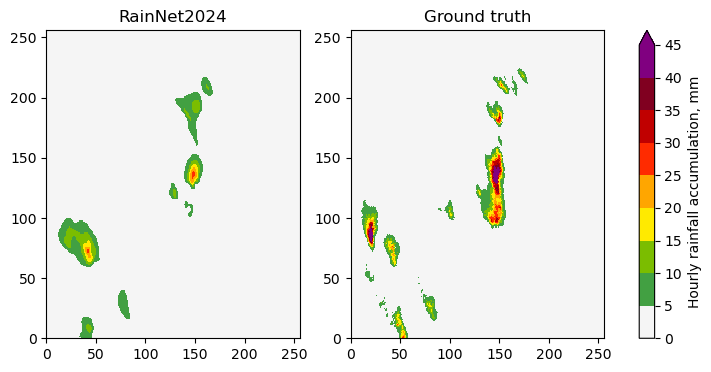

In [13]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

cmap = colors.LinearSegmentedColormap.from_list("", ["whitesmoke", "green", "yellow", "orange", "red", "maroon", "purple"])
boundaries = np.concatenate([[0], np.linspace(min(thresholds), max(thresholds), len(thresholds)+1), [45]])
norm = colors.BoundaryNorm(boundaries, cmap.N)

im1 = ax1.pcolormesh(rn24_n.sum(axis=0)/12, cmap=cmap, norm=norm)
im2 = ax2.pcolormesh(rn24_o.sum(axis=0)/12, cmap=cmap, norm=norm)

ax1.set_title("RainNet2024")
ax2.set_title("Ground truth")

fig.colorbar(im1, ax=[ax1, ax2], label="Hourly rainfall accumulation, mm", extend="max")

In [14]:
# Load the RainNet2024-S models
rn24s = {thr: load_model(os.path.join(path_models, f"rainnet2024s_{thr}.keras"),
                               custom_objects={'jaccard_loss': sm.losses.JaccardLoss(),
                                               'iou_score': sm.metrics.IOUScore(),
                                               'bce_loss': sm.losses.BinaryCELoss()}) 
         for thr in thresholds}

In [15]:
# the routine for RainNet2024-S predictions
def segmentation_nowcast(keys_for_batch, 
                         model_instance=rn24s[5], 
                         path_to_data="data/", 
                         lookback=4, 
                         pred_ts=12, 
                         threshold=5):
    """
    input: event_instance_id in the format {event_id}_{ind}
    output: nowcast in mm/h

    Parameters:
    path_to_data: YW data in .npy format for each Event_ID in CatraRe
    lookback: timesteps to consider as input
    pred_ts: how much timesteps to nowcast

    Notes:
    Input data is the YW dataset which is in mm/h.
    
    """
    dict_for_keys = l2d(keys_for_batch)
    
    # data for batch
    dict_for_data = {key:data for key, data in zip(dict_for_keys.keys(), 
                                                   [np.load(os.path.join(path_to_data, f"{k}.npy")) for k in dict_for_keys.keys()])}
       
    # batch construction
    # shape: batch, channels, W, H
    # batch_x
    batch_x = np.array([dict_for_data[k.split("_")[0]][ int(k.split("_")[1])-lookback : int(k.split("_")[1]) ] for k in keys_for_batch])
    # batch_y
    batch_y = np.array([dict_for_data[k.split("_")[0]][ int(k.split("_")[1]) : int(k.split("_")[1])+pred_ts ].sum(axis=0)/12 for k in keys_for_batch])
    
    # preprocessing
    batch_x = batch_x.astype(np.float32)
    # mm/h divided by 400 (almost max, which is 491.15)
    batch_x = batch_x / 400.0
    # move scans dimension to the last position
    batch_x = np.moveaxis(batch_x, 1, -1)

    # make prediction
    nowcast = model_instance.predict(batch_x, verbose=2)

    # post-processing
    # squeeze 
    nowcast = np.squeeze(nowcast)

    # now predictions are probs between 0 and 1
    # i want to binarize them for comparability with obs
    nowcast = np.where(nowcast>=0.5, 1.0, 0.0).astype(np.float32)

    # THIS IS WRONG
    # But it should be done as a FIX
    # We fix: nowcast should be swapped to match Y
    # That was a bug in a "buggy swap" experiment
    # nowcast = np.moveaxis(nowcast, 1, 2)
    
    # binarization
    # prob_threshold is 0.5 by default
    #nowcast = np.where(nowcast>=0.5, 1, 0)
    batch_y = np.squeeze(batch_y)
    batch_y = np.where(batch_y>=threshold, 1.0, 0.0).astype(np.float32)

    return nowcast, batch_y

In [16]:
# Here, for each threshold we predict the respective binary mask.
# Then we multiply each mask by the numerical value of the (respective threshold + 1)
# to get "quasi-accumulations". Taking the maximum of stacked accumulations together,
# we could plot the final result for different threshold on one plot.
rn24s_n = np.array([segmentation_nowcast(["20815_24"], model_instance=rn24s[thr], threshold=thr)[0] * (thr + 1) 
                    for thr in thresholds]).max(axis=0)

1/1 - 3s - 3s/epoch - 3s/step
1/1 - 2s - 2s/epoch - 2s/step
1/1 - 3s - 3s/epoch - 3s/step
1/1 - 3s - 3s/epoch - 3s/step
1/1 - 2s - 2s/epoch - 2s/step
1/1 - 2s - 2s/epoch - 2s/step
1/1 - 2s - 2s/epoch - 2s/step


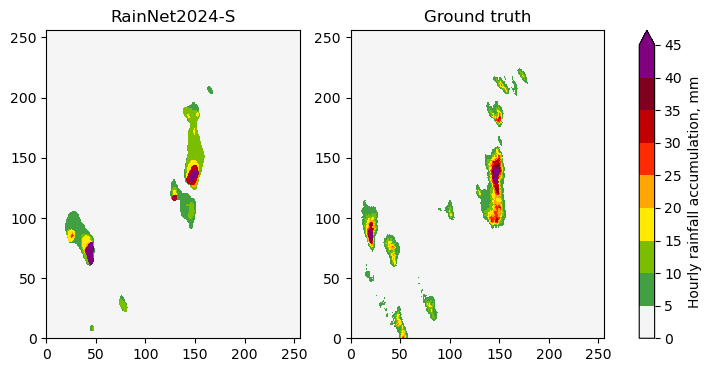

In [17]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

cmap = colors.LinearSegmentedColormap.from_list("", ["whitesmoke", "green", "yellow", "orange", "red", "maroon", "purple"])
boundaries = np.concatenate([[0], np.linspace(min(thresholds), max(thresholds), len(thresholds)+1), [45]])
norm = colors.BoundaryNorm(boundaries, cmap.N)

im1 = ax1.pcolormesh(rn24s_n, cmap=cmap, norm=norm)
im2 = ax2.pcolormesh(rn24_o.sum(axis=0)/12, cmap=cmap, norm=norm)

ax1.set_title("RainNet2024-S")
ax2.set_title("Ground truth")

fig.colorbar(im1, ax=[ax1, ax2], label="Hourly rainfall accumulation, mm", extend="max")

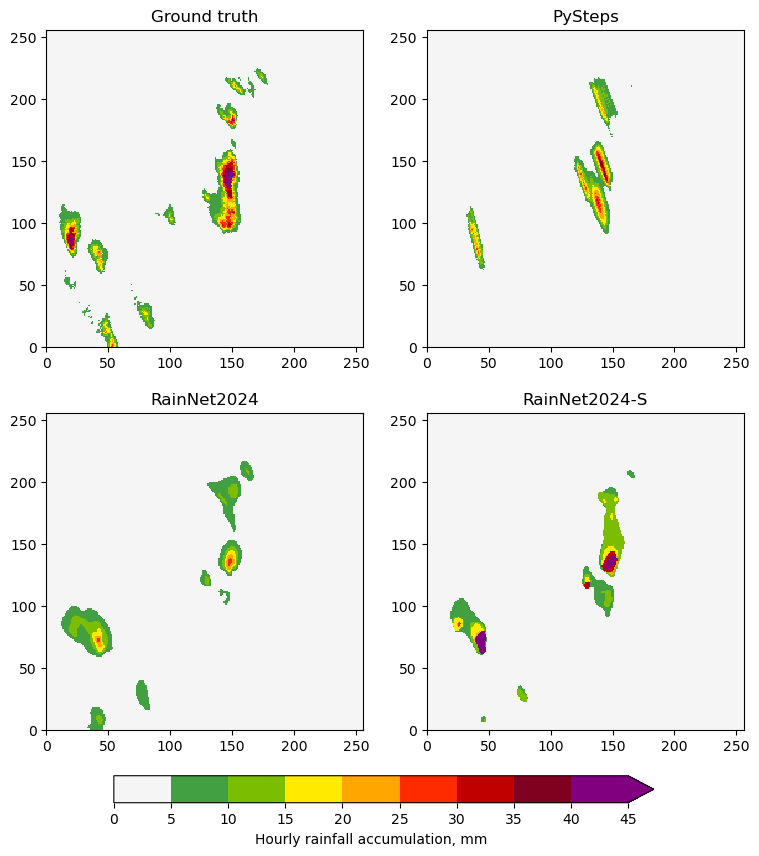

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

for ax in axes.ravel():
    ax.set_aspect('equal')

ax1, ax2, ax3, ax4 = axes.ravel()

cmap = colors.LinearSegmentedColormap.from_list("", ["whitesmoke", "green", "yellow", "orange", "red", "maroon", "purple"])
boundaries = np.concatenate([[0], np.linspace(min(thresholds), max(thresholds), len(thresholds)+1), [45]])
norm = colors.BoundaryNorm(boundaries, cmap.N)

im1 = ax1.pcolormesh(rn24_o.sum(axis=0)/12, cmap=cmap, norm=norm)
im2 = ax2.pcolormesh(pyst_n.sum(axis=0)/12, cmap=cmap, norm=norm)
im3 = ax3.pcolormesh(rn24_n.sum(axis=0)/12, cmap=cmap, norm=norm)
im4 = ax4.pcolormesh(rn24s_n, cmap=cmap, norm=norm)


ax1.set_title("Ground truth")
ax2.set_title("PySteps")
ax3.set_title("RainNet2024")
ax4.set_title("RainNet2024-S")

# Gemini advices:
# Adjust spacing to make room for colorbar
plt.subplots_adjust(bottom=0.1)  # Adjust bottom space for colorbar

# Create colorbar outside the axes (horizontal)
cax = fig.add_axes([0.2, 0.02, 0.6, 0.03])  # Adjust position as needed (x, y, width, height)
fig.colorbar(im1, cax=cax, label="Hourly rainfall accumulation, mm", extend="max", orientation='horizontal')

#fig.savefig("misc/20815_24.png", dpi=300, bbox_inches="tight")